<h1><big><center>Probabilistic Graphical Models - HW3</center></big></h1>
<h2><center>Hidden Markov Model Implementation</center></h2>

<center>
**Names**: Jean-Christophe CORVISIER - Mohammed Amine KHELDOUNI
</center>
<center>
**Emails**: jean-christophe.corvisier@eleves.enpc.fr - mkheldou@ens-paris-saclay.fr
</center>

In [19]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy
import time
import pylab

from scipy.stats import multivariate_normal

# Utils
link_of_path = r"./classification_data_HWK3/"
# link_of_path = os.getcwd() + "/"
print(link_of_path)

COLORS = ["r", "purple", "b", "g", "darkgreen"]

xlim = np.array([-10,10])
ylim = np.array([-10, 10])
steps = 1000                

def distCentroids(X,mu):
    return np.sum((mu-X)*(mu-X),axis=1)

def getDistortion(X, mu, labels, k):
    distortionMeasure = 0
    for j in range(X.shape[0]):
        distortionMeasure += distCentroids(X[j,:],mu)[int(labels[j])]
    return distortionMeasure

def plotEllipse(mu, Q, c, color="k", label=""):
    """Plots conic of equation (x-mu).T * Q * (x-mu) = c. mu and Q
    are expected to be matrices."""
    X = np.linspace(xlim[0], xlim[1], steps)
    Y = np.linspace(xlim[0], xlim[1], steps)
    X, Y = np.meshgrid(X, Y)
    Xm = X - mu[0, 0]
    Ym = Y - mu[1, 0]
    res = Xm * Xm * Q[0, 0] + 2 * Xm * Ym * Q[0, 1] + Ym * Ym * Q[1, 1] - c
    plt.contour(X, Y, res, [0], colors=color, linewidths=3)
    plt.plot([xlim[0] - 1], [ylim[0] - 1], color,
             linestyle="-", lw=3, label=label)  # Fake label
    plt.xlim(xlim)
    plt.axis('equal')
    return

./classification_data_HWK3/


In [20]:
class LearnClustering:
    def __init__(self, d=2, k=4, dataLabel="EMGaussian"):
        self.k = k
        self.d = d
        self.fileTrain = pd.read_csv(os.path.join(link_of_path, dataLabel+".data"), sep=" ", header = None)
        self.fileTest = pd.read_csv(os.path.join(link_of_path, dataLabel+".test"), sep=" ", header = None)
        self.Xtrain = self.fileTrain[[0,1]]
        self.Xtest = self.fileTest[[0,1]]
        self.Xt = np.asarray(self.Xtrain).reshape(self.Xtrain.shape[0], self.d)
        self.Xv = np.asarray(self.Xtest).reshape(self.Xtest.shape[0], self.d)
    
    def kmeans(self, X, eps=10e-20, Niter=1000):
        n = X.shape[0]
        mu = np.random.rand(self.k,self.d)
        tmp_mu = mu
        labels = np.zeros((n,1))
        diff = 5*eps
        counter = 0
        distortions = []
        while (counter < Niter and np.any(diff >= eps)):
            tmp_mu = mu.copy()
            for i in range(n):
                labels[i] = np.argmin(distCentroids(X[i,:],mu))
            for j in range(self.k):
                mu[j,:] = np.sum(X * (labels == j), axis=0) / (np.sum(labels == j, axis=0)+eps)
            diff = np.sum((tmp_mu-mu)*(tmp_mu-mu), axis=1)
            counter += 1
            distortions.append(getDistortion(X, mu, labels, self.k))
        # Calculating the cost function (distortion measure)
        return mu, labels, distortions
    
    def kmeansClusteringPlot(self, X):
        mu, labels, distortions = self.kmeans(X)
        print("Final distortion measure for the K-means algorithm: ", distortions[-1])
        
        # Plotting the distortion measure for K-means
        plt.figure(figsize=(16,8))
        plt.plot(range(len(distortions)), distortions, color = 'green', linewidth=2)
        plt.xlabel("Iterations", fontsize=16)
        plt.ylabel("Distortion measure of the K-means algorithm", fontsize=16)
        plt.show()
        
        # Plotting distortion histogram for multiple random K-means iterations
        distortionsHist = []
        for i in range(100):
            mu, labels, distortions = self.kmeans(X)
            distortionsHist.append(distortions[-1])
        plt.figure(figsize=(16,8))
        plt.hist(distortionsHist)
        plt.xlabel("Distortion values", fontsize=16)
        plt.ylabel("Distortion histogram", fontsize=16)
        plt.show()
        
        # Plotting the clustering result for K-means algorithm
        plt.figure(figsize=(16,8))
        for i in range(self.k):
            if (i==0):
                ax = pd.DataFrame(X)[labels==i].plot(kind='scatter', x=0,y=1, c=COLORS[i], figsize = (16,8), label = "Cluster " + str(i+1))
            else:
                pd.DataFrame(X)[labels==i].plot(kind='scatter', x=0,y=1, c=COLORS[i], figsize = (16,8), ax=ax, label = "Cluster " + str(i+1))
            plt.scatter(mu[i,0], mu[i,1], edgecolors=COLORS[i], linewidths = 10, marker='*', label = "Centroid for label " + str(i+1))
        plt.xlabel("Data first feature", fontsize=16)
        plt.ylabel("Data second feature", fontsize=16)
        plt.legend(loc=2, scatterpoints = 1)
        plt.show()
    
    def likelihood(self, X, theta):
        """ This function computes the Expected complete log-likelihood """
        [alpha, mu, sigma] = theta
        normal = np.zeros((X.shape[0],self.k))
        alpha = np.array(alpha)
        for j in range(self.k):
            normal[:,j] = 1./((2*np.pi)**(self.d/2)*np.sqrt(np.linalg.det(sigma[j]))) * np.exp(-0.5*np.sum((X-mu[j]).dot(np.linalg.inv(sigma[j]))*(X-mu[j]), axis=1))

        tau = self.computeTau(X, theta)
        L = np.multiply(tau, np.log(normal+1e-20)) + np.multiply(tau, np.log(alpha+1e-20))
        return np.sum(L)


    def computeTau(self, X, theta):
        """
        inputs: X (Nx2) matrix of data we want to classify into k clusters
        theta: the parameters of the model. For a GMM, we have theta = [alpha, mu, sigma]
        outputs: tau (Nxk) matrix of probability distribution of z|x,theta 
        following the course notation.
        """
        [alpha, mu, sigma] = theta
        # E-step
        tau_tilde = np.zeros((X.shape[0],self.k))
        for j in range(self.k):
            tau_tilde[:,j] = alpha[j]/((2*np.pi)**(self.d/2)*np.sqrt(np.linalg.det(sigma[j]))) * np.exp(-0.5*np.sum((X-mu[j]).dot(np.linalg.inv(sigma[j]))*(X-mu[j]), axis=1))

        tau = np.divide(tau_tilde,np.sum(tau_tilde,axis=1).reshape(tau_tilde.shape[0],1))
        return tau
    
    
    def trainEM(self, X, theta_init, Niter=100):
        """ This function output the optimal parameters by running an EM algorithm
        and computing the estimators of our Gaussian Mixtures Model.
        """
        counter = 0
        [alpha, mu, sigma] = theta_init
        n = X.shape[0]
        likelihoods = []
        while(counter < Niter):
            # E-step
            tau = self.computeTau(X,[alpha, mu, sigma])
            likelihoods.append(self.likelihood(X, [alpha, mu, sigma]))
            # M-step
            alpha = np.sum(tau, axis=0) / np.sum(tau)
            for j in range(self.k):
                mu[j] = np.sum(tau[:,j].reshape(n,1)*X,axis=0)/np.sum(tau[:,j])
                sigma[j] = (X-mu[j]).transpose().dot(tau[:,j].reshape(X.shape[0],1)*(X-mu[j]))/np.sum(tau[:,j])

            counter += 1

        theta = [alpha, mu, sigma]

        return theta, likelihoods
    
    def predictEM(self, X, theta_opt):
        tau = self.computeTau(X, theta_opt)
        Z = np.argmax(tau, axis=1)
        return Z.reshape(-1,1)
    
    def plotCluster(self, data):
        pylab.figure(figsize=(20,15))
        self.K = 4
        [alpha, mu, sigma] = theta_opt
        labels = self.predictEM(data, theta_opt)
        for i in range(self.K):
            cluster = data[labels[:,0] == i, :]
            pylab.scatter(cluster[:, 0], cluster[:, 1], color=COLORS[i], lw=2, label='Cluster '+str(i))
            plotEllipse(mu[i, :][:, None], np.linalg.inv(np.asmatrix(sigma[i, :, :])),
                         -2*np.log(0.1), color=COLORS[i])
            pylab.scatter(mu[i, 0], mu[i, 1],
                        color=COLORS[i], marker="*", lw=8)
        pylab.xlim(xlim)
        pylab.ylim(ylim)
        pylab.xlabel("Data first feature", fontsize=18)
        pylab.ylabel("Data second feature", fontsize=18)
        pylab.legend(loc=2, scatterpoints = 1)
        pylab.show()
        

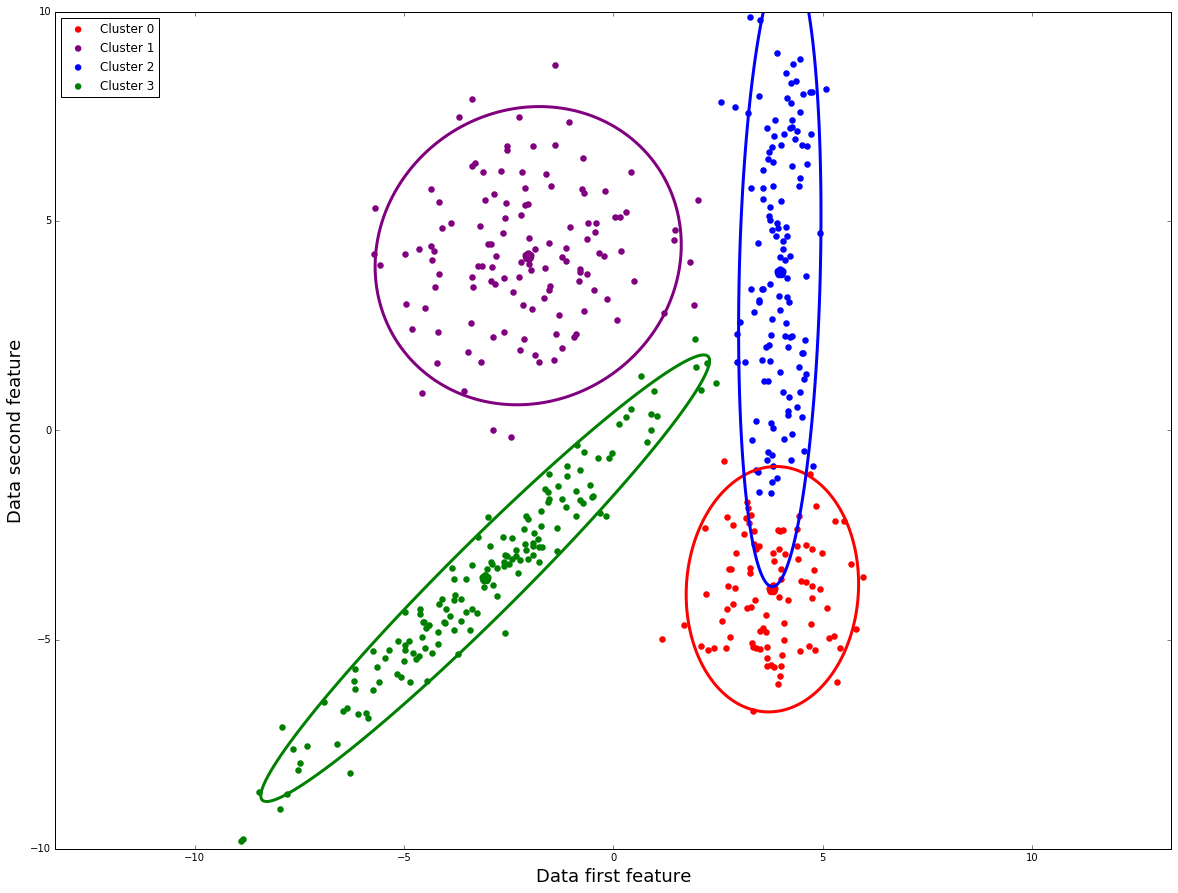

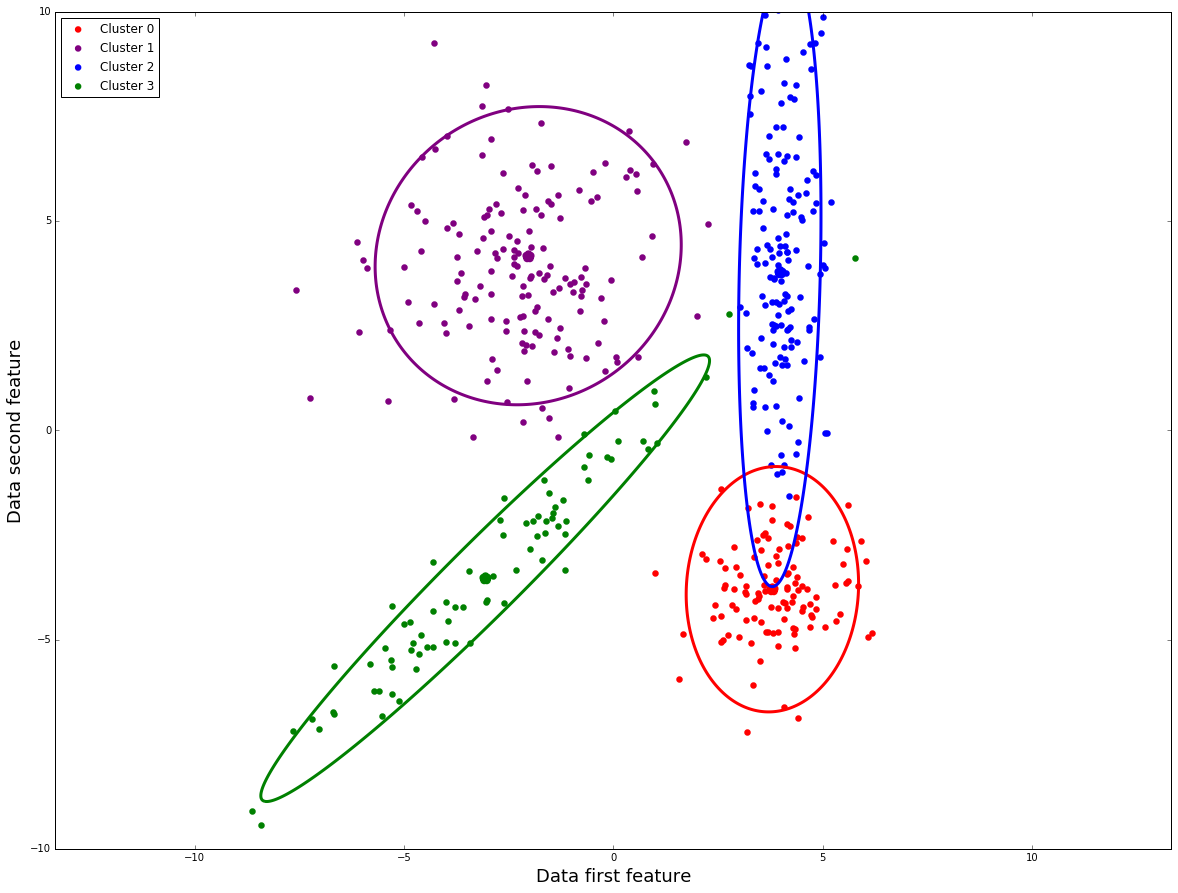

In [21]:
model = LearnClustering()
mu, labels, distortion = model.kmeans(model.Xt)
mu, labels, distortion = model.kmeans(model.Xt)
# Initialization of EM algorithm by random parameters and K-Means
alpha_init = [0.3,0.4, 0.2, 0.1]
mu_init = mu
sigma_init = np.array([[[1,0.3],[0.3,1]],[[1,0.3],[0.3,1]], [[1,-0.4],[-0.4,1]], [[0.1,0],[0,0.1]]])
theta_opt, likelihoods = model.trainEM(model.Xt, [alpha_init,mu_init,sigma_init])
# print(theta_opt)
# plt.figure(figsize=(16,8))
# plt.plot(likelihoods, color = 'blue', linewidth=2)
# plt.xlabel("Iterations", fontsize=16)
# plt.ylabel("Complete likelihood of the GMM", fontsize=16)
# plt.show()
model.plotCluster(model.fileTrain.values[:, :])
model.plotCluster(model.fileTest.values[:, :])

In [22]:
class HMM:
    def __init__(self, mu_start, sigma_start, d = 2, K = 4, dataLabel="EMGaussian"):
        self.train_data = pd.read_csv(link_of_path+dataLabel+'.data', delimiter=' ', header=None).values[:, :]
        self.test_data = pd.read_csv(link_of_path+dataLabel+'.test', delimiter=' ', header=None).values[:, :]
        self.T = len(self.train_data)
        self.d = 2
        
        # states variables
        self.K = 4
        self.states = range(self.K)
        #initialization of the distribution pi, here we take a
        #random initialization
        self.pi = np.random.rand(self.K)
        # the probability transition matrix, randomly initialized
        self.a = np.random.rand(self.K,self.K)
        self.a = self.a / np.sum(self.a, axis = 1) 
        
        #parameters of the gaussians (assumption for the emission proba)
        #we initialize them with the previous ones found in the GMM model
        self.mu = mu_start
        self.sigma = sigma_start

    # Compute the emission probabilities (based on gaussian assumptions here)
    def computeEmissionProbabilities(self, data):
        self.emission_probabilities = np.zeros((self.T, self.K))
        self.log_emission_probabilities = np.zeros((self.T, self.K))
        for j in range(self.K):
            self.emission_probabilities[:,j] = 1. / ((2 * np.pi) ** (self.d /2) * np.sqrt(np.linalg.det(self.sigma[j]))) * np.exp(-0.5 * np.sum((data - self.mu[j]).dot(np.linalg.inv(self.sigma[j])) * (data - self.mu[j]), axis = 1))
            self.log_emission_probabilities[:,j] = np.log(self.emission_probabilities[:,j])
        
        return

    # alpha recursion, we use log to avoid numerical errors
    def computeAlphaRecursion(self):
        self.log_alpha = np.zeros((self.T, self.K))
        # Initialize of alpha(0)  with p(z0)
        self.log_alpha[0, :] = np.log(self.pi * self.emission_probabilities[0, :])
   
        for t in range(self.T - 1):
            log_alpha_max = np.max(self.log_alpha[t, :])
            for q in self.states:
                self.log_alpha[t + 1, q] = self.log_emission_probabilities[t + 1, q] + log_alpha_max + np.log(sum((np.exp(self.log_alpha[t, q_t_1] - log_alpha_max) * self.a[q_t_1, q])
                               for q_t_1 in self.states))

    # We compute here the beta recursion 
    # using log here to avoid calculus error
    def computeBetaRecursion(self):
        self.log_beta = np.zeros((self.T, self.K))
        #initialization of beta(T) at 1
        for q in self.states:
            self.log_beta[self.T - 1, q] = 0
        for t in range(self.T - 2,-1,-1):
            log_beta_max = np.max(self.log_beta[t + 1, :])
            for q in self.states:
                self.log_beta[t, q] = log_beta_max + np.log(sum((np.exp(self.log_beta[t + 1, q_next] - log_beta_max) * self.a[q, q_next] * self.emission_probabilities[t + 1, q_next]) 
                                                                 for q_next in self.states))
    
    # We compute alpha, beta, emission probas
    # p(z_t = i|u,theta), p(z_t = i,z_t+1 = j |u, theta)
    def computeEStep(self, data=np.array([])):
        if data.size == 0:
            data = self.train_data

        self.computeEmissionProbabilities(data)
        self.computeAlphaRecursion()
        self.computeBetaRecursion()

        # initialize the probas for p(z_t = i|u,theta), p(z_t = i,z_t+1 = j |u, theta)
        self.proba_q_t = np.zeros((self.T, self.K))
        self.proba_q_q_t = np.zeros((self.T - 1, self.K, self.K))

        for t in range(self.T):
            max_alpha_beta = np.max(self.log_alpha[t, :] + self.log_beta[t, :])
            proba_sum_alpha_beta = sum((np.exp(self.log_alpha[t, q] + self.log_beta[t, q] - max_alpha_beta ))
                                       for q in self.states)
            
            for q in self.states:
                self.proba_q_t[t, q] = np.exp(
                    self.log_alpha[t, q] + self.log_beta[t, q] - max_alpha_beta) / proba_sum_alpha_beta
            
            if t < self.T - 1:
                for i in self.states:
                    for j in self.states:
                        self.proba_q_q_t[t, i, j] = np.exp(self.log_alpha[t, i] + 
                                                           self.log_beta[t + 1, j] - max_alpha_beta) * self.emission_probabilities[t + 1, j] * self.a[i, j] / proba_sum_alpha_beta
        return
        
    # log-likelihood (complete ,expectation)
    def likelihood(self):
        Proba_Z_0 = np.sum(self.proba_q_t[0, :] * np.log(self.pi))
        #calcul of P_transition
        Proba_transition = 0
        for t in range(self.T-1):
            for i in range(self.K):
                for j in range(self.K):
                    Proba_transition += self.proba_q_q_t[t, j, i] * np.log(self.a[i,j]) 
        Proba_emission_probabilities = np.sum(self.proba_q_t * np.log(self.emission_probabilities))
        return Proba_Z_0+ Proba_transition + Proba_emission_probabilities 

    
    #EM algorithm on the HMM model
    #To avoid numerical issues, we decided to put a stopping criterion on the
    #maximum error between the parameters found on iteration k and iteration k+1
    #otherwise, the values became too small and we have issues in the log
    def trainEM(self, Niter=100, eps = 1e-5):
        self.likelihoodValues = []
        max_value_error = 1
        i = 0
        while i < Niter and max_value_error > eps:
            #saving the previous found theta
            pi_previous, a_previous, mu_previous, sigma_previous = self.pi, self.a, self.mu, self.sigma
            
            # E-step
            self.computeEStep(self.train_data)
            
            
            # M-step
            #updating thanks to our formulas the pi0
            self.pi = self.proba_q_t[0, :]
            
            #estimating the transition matrix
            for i in range(self.K):
                for j in range(self.K):
                    #sum on t
                    sum_proba_i_j = np.sum(self.proba_q_q_t[:,j,i])
                    #sum on j and t
                    sum_proba_i = np.sum(self.proba_q_q_t[:,:,i])
                    self.a[i,j] = sum_proba_i_j / (1.0 * sum_proba_i)
    
            # estimating the mu's
            for i in range(self.K):
                self.mu[i] = np.zeros((2,))
                sum_proba_i = 0
                for t in range(self.T):
                    self.mu[i] += self.train_data[t,:] * self.proba_q_t[t,i]
                    sum_proba_i += self.proba_q_t[t,i]
                self.mu[i] /= sum_proba_i
        
            #estimating the sigma's
            self.sigma = np.zeros((self.K, 2, 2))
            for i in range(self.K):
                sum_proba_i = 0
                self.sigma[i] = np.zeros((2,2))
                for t in range(self.T):
                    data = self.train_data[t,:]
                    data = data.reshape((-1,1))
                    mu = self.mu[i]
                    mu = mu.reshape((-1,1))
                    self.sigma[i] += np.dot((data - mu), (data - mu).T) * self.proba_q_t[t,i]
                    sum_proba_i += self.proba_q_t[t,i]
                self.sigma[i] /= sum_proba_i

            # log-likelihood
            train_likelihood = self.likelihood()
            self.likelihoodValues.append(train_likelihood)
            #updating the max error on the parameters
            max_value_error = max(np.max(np.abs(self.pi - pi_previous)), np.max(np.abs(self.a - a_previous)),
                                  np.max(np.abs(self.mu - mu_previous)), np.max(np.abs(self.sigma - sigma_previous)))
            i += 1
            
#         Uncomment to display the complete log likelihood
#         plt.figure(figsize=(16,8))
#         plt.plot(np.arange(i), self.likelihoodValues, label = "EM values")
#         plt.xlabel('Iterations', fontsize=14)
#         plt.ylabel('Complete Log-likelihood', fontsize=14)
#         plt.show()
        #return the found theta
        return [self.pi, self.a, self.mu, self.sigma]
    
    def computeInferenceAlgorithm(self, data):
        T = len(data)
        self.labels = np.zeros(T)
        self.states_Matrix = np.zeros((T, self.K))
        #log Proba ici
        self.log_proba_Matrix = np.zeros((T, self.K))
        
        #we store here the logarithm of the needed probabilities :
        #transition matrix, emission_probabilities (gaussian) and probabilty pi0
        log_pi = np.log(self.pi)
        log_a = np.log(self.a)
        log_gaussian = np.log(self.emission_probabilities)
        
        #initialization of Matrix Proba with t = 0
        self.log_proba_Matrix[0, :] = log_pi + log_gaussian[0, :]
        #using a similar formula for the alpha, except that we replace the sum by the max
        for t in range(0, T-1):
            for q in self.states:
                self.log_proba_Matrix[t+1, q] = np.max([self.log_proba_Matrix[t, k] + log_a[k, q] + log_gaussian[t+1, q]
                                                 for k in self.states]) 
                self.states_Matrix[t, q] = np.argmax([self.log_proba_Matrix[t, k] + log_a[k, q] + log_gaussian[t+1, q] 
                                                for k in self.states])                                                  

        # retrieving the right state (label here)
        self.labels[T-1] = np.argmax(self.log_proba_Matrix[T - 1, :])
        for t in range(T-2, -1, -1):
            self.labels[t] = self.states_Matrix[t, int(self.labels[t + 1])]
    
    def plotCluster(self, data, path):
        plt.figure(figsize=(20,15))
        for i in range(self.K):
            cluster = data[path == i, :]
            plt.scatter(cluster[:, 0], cluster[:, 1], color=COLORS[i], lw=2, label='Cluster '+str(i))
            plotEllipse(self.mu[i, :][:, None], np.linalg.inv(np.asmatrix(self.sigma[i, :, :])),
                         -2*np.log(0.1), color=COLORS[i])
            pylab.scatter(mu[i, 0], mu[i, 1],
                        color=COLORS[i], marker="*", lw=8)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xlabel("Data first feature", fontsize=18)
        plt.ylabel("Data second feature", fontsize=18)
        plt.legend(loc=2, scatterpoints = 1)
        plt.show()


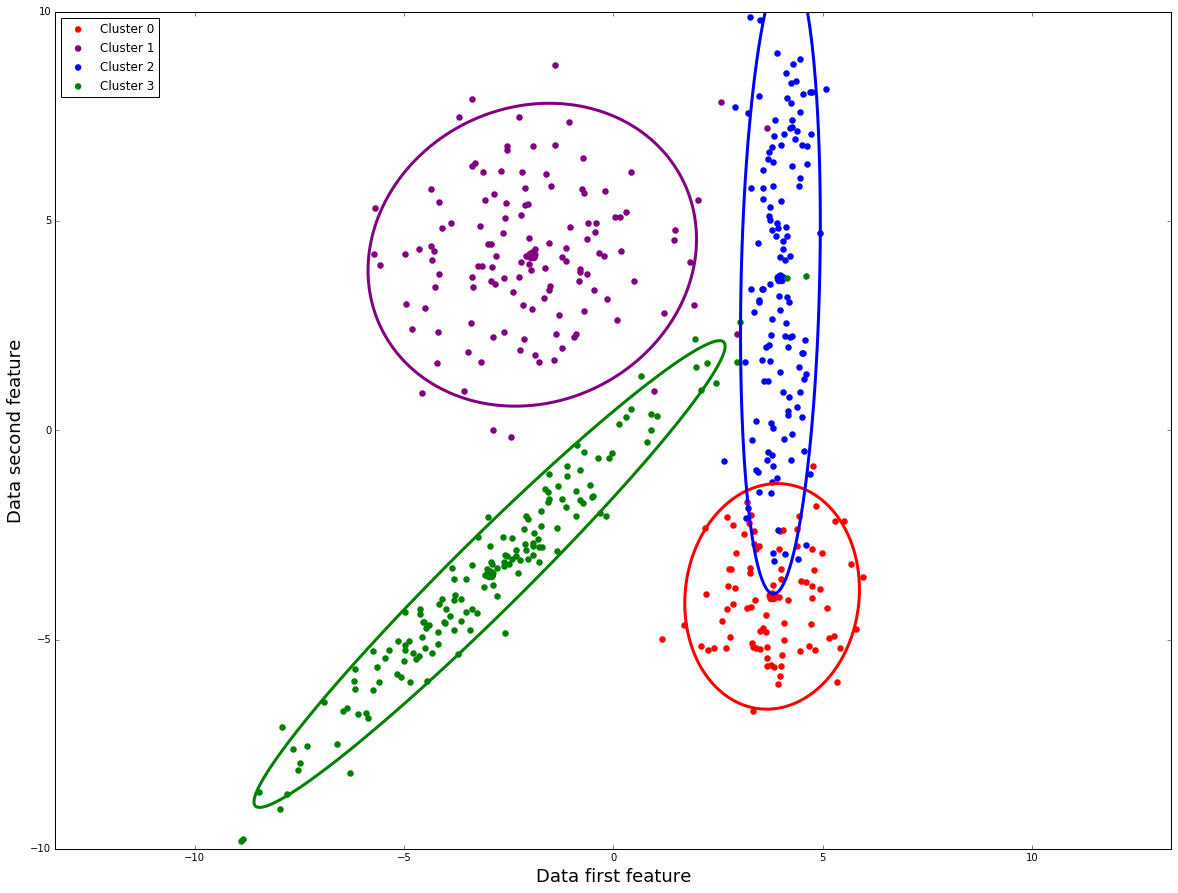

likelihood on train:  -3.81450055309


In [23]:
#creating HMM with initialization with parameters given by the GMM 
hmm = HMM(theta_opt[1], theta_opt[2])
hmm.computeEStep()
params = hmm.trainEM()
#computing the labels
hmm.computeInferenceAlgorithm(hmm.train_data)
hmm.plotCluster(hmm.train_data, hmm.labels)
print("likelihood on train: ", hmm.likelihood()/len(hmm.train_data))

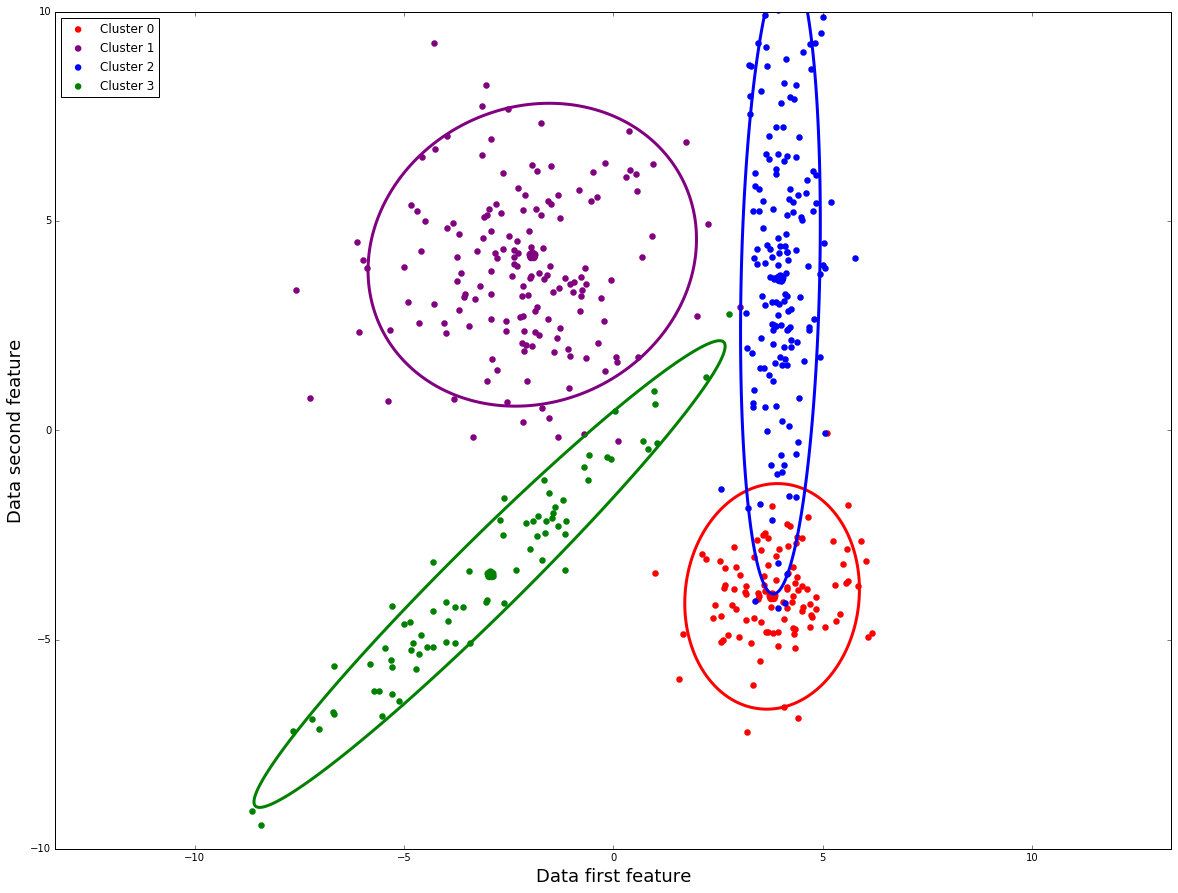

likelihood on test:  -3.91739721721


In [24]:
# Test data
hmm.computeEStep(hmm.test_data)
hmm.computeInferenceAlgorithm(hmm.test_data)
hmm.plotCluster(hmm.test_data, hmm.labels)
print("likelihood on test: ", hmm.likelihood()/len(hmm.test_data))